In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import lenspyx
import os
import healpy as hp

In [2]:
from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl
from plancklens.utils import alm_copy


In [3]:

def alm_copy(alm, lmax=None):
    """Copies the healpy alm array, with the option to reduce its lmax

    Args:
        alm (ndarray): healpy alm array.
        lmax (int, optional): new alm lmax.
    """
    alm_lmax = int(np.floor(np.sqrt(2 * len(alm)) - 1))
    assert lmax <= alm_lmax, (lmax, alm_lmax)
    if (alm_lmax == lmax) or (lmax is None):
        ret = np.copy(alm)
    else:
        ret = np.zeros((lmax + 1) * (lmax + 2) // 2, dtype=np.complex128)
        for m in range(0, lmax + 1):
            ret[((m * (2 * lmax + 1 - m) // 2) + m):(m * (2 * lmax + 1 - m) // 2 + lmax + 1)] \
                = alm[(m * (2 * alm_lmax + 1 - m) // 2 + m):(m * (2 * alm_lmax + 1 - m) // 2 + lmax + 1)]
    return ret

In [4]:
# Geometry on which to produce the lensed map
geom_info = ('healpix', {'nside':2048}) # here we will use an Healpix grid with nside 2048

# Unlensed T map is this:
geom = lenspyx.get_geom(geom_info)

In [54]:
#case = "websky"
case = "webskyrand"
#case = "webskygauss"

if case == "webskyrand":
    main_dir = "S4WebskyWebskyBornRand"
elif case == "websky":
    main_dir = "S4WebskyWebskyBorn"
elif case == "webskygauss":
    main_dir = "S4WebskyWebskyBornGauss"


idxs = [0, 1, 2]

Wiener = True

for idx in idxs:

    if not Wiener:
        plmin = hp.read_alm(f"/Users/omard/Downloads/SCRATCHFOLDER/n32/{main_dir}/cmbs/plm_in_{idx}_lmax5120.fits")
        dlmin = almxfl(plmin, np.sqrt(np.arange(lmaxin + 1, dtype=float) * np.arange(1, lmaxin + 2)), None, False)
    else:
        plmQEWiener = np.load(f"/Users/omard/Downloads/SCRATCHFOLDER/n32/{main_dir}/lenscarfrecs/ptt_sim{idx:04}/phi_plm_it000.npy")
        dlminWF = almxfl(plmQEWiener, np.sqrt(np.arange(lmax + 1, dtype=float) * np.arange(1, lmax + 2)), None, False)


    codetlm = hp.read_alm(f"/Users/omard/Downloads/SCRATCHFOLDER/n32/{main_dir}/cmbs/sim_{idx:04}_tlm.fits").astype(np.complex128)
    clcodetlm = hp.alm2cl(codetlm)

    if not Wiener:
        WFQE = np.loadtxt(f"/Users/omard/Documents/projects/fgcmblensing/iterativeforegroundsfullsky/itfgs/notebooks/WFQE.txt")
        dlminWF = hp.almxfl(dlmin, WFQE)

    delTlenInWF =  lenspyx.alm2lenmap([codetlm], -dlminWF, geometry = geom_info, verbose = 1, epsilon = epsilon)[0]
    delTlenInalmWF = hp.map2alm(delTlenInWF, lmax = lmax, iter = 0)

    if not Wiener:
        hp.write_alm(f"{case}_delensed_in_tlm_{idx}.fits", delTlenInalmWF, overwrite = True)
    else:
        hp.write_alm(f"{case}_delensed_tlm_{idx}.fits", delTlenInalmWF, overwrite = True)

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:04.824364] (73.8%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.303736] (4.6%)  
  build_angles                         :  [0:00:05.128115] (78.5%)  
  synthesis general (STANDARD)         :  [0:00:01.404444] (21.5%)  
  gclm2lenmap                          :  [0:00:06.532615] (100.0%)  
  Total                                :  [0:00:06.532709] d:h:m:s:mus
alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:05.358905] (67.0%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.424402] (5.3%)  
  build_angles                         :  [0:00:05.785789] (72.3%)  
  synthesis general (STANDARD)         :  [0:00:02.163098] (27.0%)  
  gclm2lenmap                          :  [0:00:07.946463] (99.3%)  
  Total                                :  [0:00:08.001396] d:h:m:s:mus
alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:04.765230] (68.1%)  
  build angle

In [35]:
file = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs/ptt_sim0000/normalized_phi_plm_it000.npy"
plmQE = np.load(file)
plmQEWiener = np.load("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs/ptt_sim0000/phi_plm_it000.npy")

plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/plm_in_0_lmax5120.fits")



#just take any cls for unlensed for now

cls_path = os.path.join(os.path.dirname(os.path.abspath(lenspyx.__file__)), 'data', 'cls')

cl_len = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))

lmax_unl = 4096
mmax_unl = lmax_unl

tlm_unl = synalm(cl_unl['tt'], lmax=lmax_unl, mmax=mmax_unl)

tunlmap =  hp.alm2map(tlm_unl, nside = 2048)

In [6]:
lmax = hp.Alm.getlmax(plmQE.shape[-1])
lmax

4500

In [7]:
plmincopy = alm_copy(plmin, lmax)

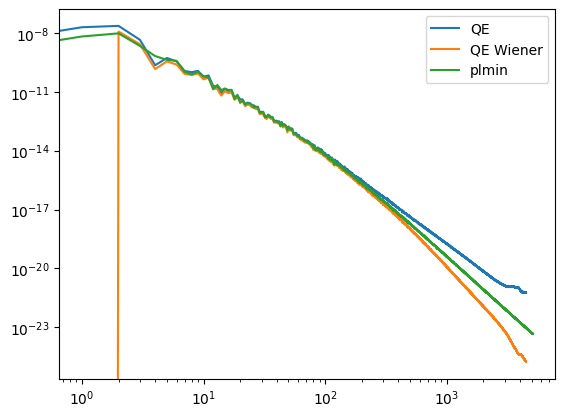

In [8]:
clQE = hp.alm2cl(plmQE, lmax = lmax)
clQEWiener = hp.alm2cl(plmQEWiener, lmax = lmax)

plt.loglog(clQE, label = "QE")
plt.loglog(clQEWiener, label = "QE Wiener")
plt.loglog(hp.alm2cl(plmin), label = "plmin")
plt.legend()

In [9]:
lmaxin = hp.Alm.getlmax(plmin.shape[-1])

In [10]:
dlmin = almxfl(plmin, np.sqrt(np.arange(lmaxin + 1, dtype=float) * np.arange(1, lmaxin + 2)), None, False)

dlm = almxfl(plmQE, np.sqrt(np.arange(lmax + 1, dtype=float) * np.arange(1, lmax + 2)), None, False)
dlmWiener = almxfl(plmQEWiener, np.sqrt(np.arange(lmax + 1, dtype=float) * np.arange(1, lmax + 2)), None, False)

In [11]:
epsilon = 1e-6
Tlen = lenspyx.alm2lenmap([tlm_unl], dlmin, geometry = geom_info, verbose = 1, epsilon = epsilon)[0]


alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:06.267931] (78.5%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.280350] (3.5%)  
  build_angles                         :  [0:00:06.548299] (82.0%)  
  synthesis general (STANDARD)         :  [0:00:01.433192] (18.0%)  
  gclm2lenmap                          :  [0:00:07.981525] (100.0%)  
  Total                                :  [0:00:07.981632] d:h:m:s:mus


In [12]:
Tlenalm = hp.map2alm(Tlen, lmax = lmax, iter = 0)

In [13]:
codetlm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_tlm.fits")
clcodetlm = hp.alm2cl(codetlm)


In [14]:
codemap = hp.alm2map(codetlm, nside = 2048)

In [15]:
Tlenalm = codetlm.astype(np.complex128)

In [16]:
delTlenQE =  lenspyx.alm2lenmap([Tlenalm], -dlm, geometry = geom_info, verbose = 1, epsilon = epsilon)[0]


alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:04.908875] (74.3%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.400064] (6.1%)  
  build_angles                         :  [0:00:05.309005] (80.4%)  
  synthesis general (STANDARD)         :  [0:00:01.296696] (19.6%)  
  gclm2lenmap                          :  [0:00:06.605701] (100.0%)  
  Total                                :  [0:00:06.605961] d:h:m:s:mus


In [17]:
delTlenQEWiener =  lenspyx.alm2lenmap([Tlenalm], -dlmWiener, geometry = geom_info, verbose = 1, epsilon = epsilon)[0]

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:05.392993] (71.9%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.363553] (4.8%)  
  build_angles                         :  [0:00:05.756567] (76.8%)  
  synthesis general (STANDARD)         :  [0:00:01.743628] (23.2%)  
  gclm2lenmap                          :  [0:00:07.500238] (100.0%)  
  Total                                :  [0:00:07.500364] d:h:m:s:mus


In [20]:
delTlenQEWieneralm = hp.map2alm(delTlenQEWiener, lmax = lmax, iter = 0)

In [21]:
idx = 0
hp.write_alm(f"delensed_tlm_{idx}.fits", delTlenQEWieneralm)

In [39]:
WFQE = np.loadtxt(f"/Users/omard/Documents/projects/fgcmblensing/iterativeforegroundsfullsky/itfgs/notebooks/WFQE.txt")
dlminWF = hp.almxfl(dlmin, WFQE)
delTlenInWF =  lenspyx.alm2lenmap([Tlenalm], -dlminWF, geometry = geom_info, verbose = 1, epsilon = epsilon)[0]
delTlenInalmWF = hp.map2alm(delTlenInWF, lmax = lmax, iter = 0)
idx = 0
hp.write_alm(f"delensed_in_tlm_{idx}.fits", delTlenInalmWF, overwrite = True)

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:06.414793] (71.9%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.301958] (3.4%)  
  build_angles                         :  [0:00:06.716849] (75.3%)  
  synthesis general (STANDARD)         :  [0:00:02.207314] (24.7%)  
  gclm2lenmap                          :  [0:00:08.924216] (100.0%)  
  Total                                :  [0:00:08.924745] d:h:m:s:mus


ValueError: zero-size array to reduction operation maximum which has no identity

In [22]:
delTlenIn =  lenspyx.alm2lenmap([Tlenalm], -dlmin, geometry = geom_info, verbose = 1, epsilon = epsilon)[0]

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:05.657503] (71.8%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.272399] (3.5%)  
  build_angles                         :  [0:00:05.929920] (75.3%)  
  synthesis general (STANDARD)         :  [0:00:01.945895] (24.7%)  
  gclm2lenmap                          :  [0:00:07.875894] (100.0%)  
  Total                                :  [0:00:07.877423] d:h:m:s:mus


In [23]:
delTlenQEalm = hp.map2alm(delTlenQE, lmax = lmax, iter = 0)
delTlenQEWieneralm = hp.map2alm(delTlenQEWiener, lmax = lmax, iter = 0)
delTlenInalm = hp.map2alm(delTlenIn, lmax = lmax, iter = 0)

In [24]:
clslen = hp.alm2cl(Tlenalm)#, lmax = lmax)
clsunlen = hp.alm2cl(tlm_unl)

In [25]:
clsdelTlenQE = hp.alm2cl(delTlenQEalm, lmax = lmax)
clsdelTlenQEWiener = hp.alm2cl(delTlenQEWieneralm, lmax = lmax)
clsdelTlenIn = hp.alm2cl(delTlenInalm, lmax = lmax)

In [26]:
ls = np.arange(0, lmax + 1)
lsunlen = np.arange(0, lmax_unl + 1)

lcode = np.arange(0, len(clcodetlm))


(1000.0, 10000.0)

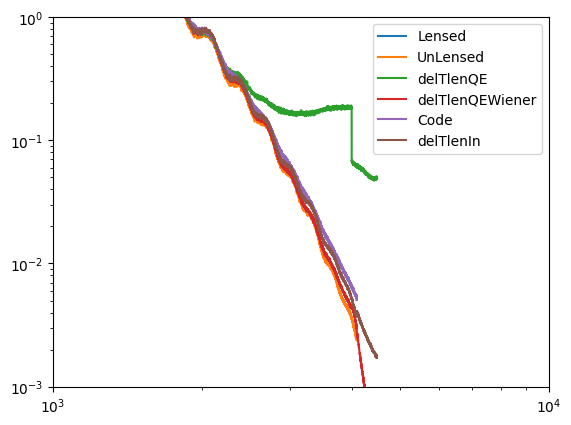

In [29]:
plt.loglog(lcode*clslen, label = "Lensed")
plt.loglog(lsunlen*clsunlen, label = "UnLensed")
plt.loglog(ls*clsdelTlenQE, label = "delTlenQE")
plt.loglog(ls*clsdelTlenQEWiener, label = "delTlenQEWiener")
plt.loglog(lcode*clcodetlm, label = "Code")
plt.loglog(ls*clsdelTlenIn, label = "delTlenIn")
plt.legend()
plt.ylim(1e-3, 1e0)
plt.xlim(1e3, 1e4)

In [38]:
deltaT = (delTlenIn - tunlmap)
Tlen2 = deltaT**2
Tlen2alm = hp.map2alm(Tlen2, lmax = lmax, iter = 0)

deltaT = (delTlenQEWiener - tunlmap)
delTlenQEWiener2 = deltaT**2
delTlenQEWiener2alm = hp.map2alm(delTlenQEWiener2, lmax = lmax, iter = 0)

In [39]:
lencrosscorr = hp.alm2cl(Tlen2alm, plmincopy)

delcrosscorr = hp.alm2cl(delTlenQEWiener2alm, plmincopy)

inin = hp.alm2cl(plmincopy)

In [40]:
import scipy

def bin_theory(l, lcl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, lcl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    return cl


bin_edges = np.arange(10, 4000, 100)



In [41]:

lencrosscorrbin = bin_theory(ls, ls*lencrosscorr, bin_edges)
delcrosscorrbin = bin_theory(ls, ls*delcrosscorr, bin_edges)

ininbin = bin_theory(ls, ls*inin, bin_edges)

elbin = (bin_edges[:-1] + bin_edges[1:]) / 2

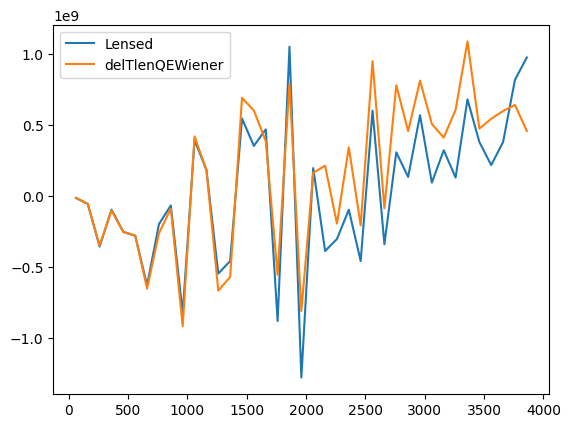

In [42]:
plt.plot(elbin, lencrosscorrbin/ininbin, label = "Lensed")
plt.plot(elbin, delcrosscorrbin/ininbin, label = "delTlenQEWiener")
plt.legend()

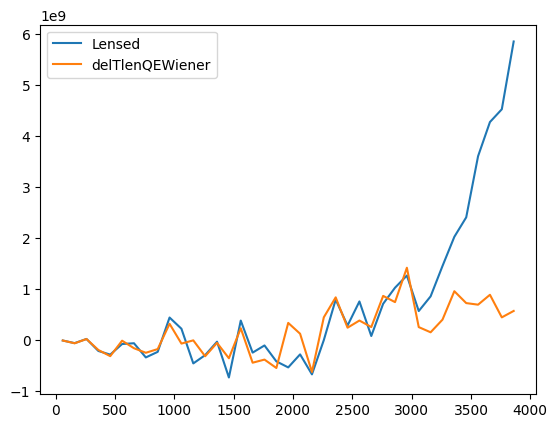

In [ ]:
plt.plot(elbin, lencrosscorrbin/ininbin, label = "Lensed")
plt.plot(elbin, delcrosscorrbin/ininbin, label = "delTlenQEWiener")
plt.legend()